# Beamforming

Beamforming is based on the fact that signal (here sound) arrives at different times at distributed (array of) sensors (here hydrophones).

While the direction of single sound source may be estimated ba measuring the relative delays within the hydrophone array and relating these measurements to the array geometry, beamforming analyses the arriving sound field for all possible direections (beams).

## Basic formulation of single source direction finding
Let the sound direction  $\hat S$ be given by 

\begin{equation}
    \hat S = 
    \left(
        \begin{array}{c}
            S_x\\
            S_y\\
            S_z
        \end{array}
    \right)  
\end{equation}
and the hydrophone location matrix $ H $ be given by

\begin{equation}
     H = 
    \left(
        \begin{array}{c c c c}
            h_{0x} & h_{1x} & ... & h_{nx}\\
            h_{0y} & h_{1y} & ... & h_{ny}\\
            h_{0z} & h_{1z} & ... & h_{nz}\\
        \end{array}
    \right)  
\end{equation}
where the elements $(d_{ix},d_{iy},d_{iz}) $ are the $x,y,z$ components of the 3-D vector that locates the hydrophones.

Let $D_0$ be the hydrophone seperation matrix

\begin{equation}
     D_0 = H-{h_0}=
    \left(
        \begin{array}{c c c c}
            d_{1x} & d_{2x} & ... & d_{nx}\\
            d_{1y} & d_{2y} & ... & d_{ny}\\
            d_{1z} & d_{2z} & ... & d_{nz}\\
        \end{array}
    \right)  
\end{equation}

then the vector of measurements $ m$ defined by 

\begin{equation}
     m = 
    \left(
        \begin{array}{c}
            m_1\\
            m_2\\
            \vdots\\
            m_n
        \end{array}
    \right)  
\end{equation}

is estimated by the projection of the sound source direction onto the different hydrophone pairs.


\begin{equation}
     m =  D_0^T  {\hat S}
\end{equation}

The sound direction is then estimated from the measurement vector by

\begin{equation}
    {\hat S} = \left( D_0^T  D_0 \right)^{-1}  D_0  m
\end{equation}

### Line array
In case where the array geometry is a line array then typically one assumes that $(h_{iy},h_{iz})=(0,0)$ and we get

\begin{equation}
    \hat S_x = \frac{\sum_i(d_{ix}m_i)} {\sum_i(d_{ix}^2)}
\end{equation}

## Basic formulation of beamforming
Let the sound pressure measured an a single hydrophone be a signal $s$

\begin{equation}
x(t)=s(t)
\end{equation}

then in an array of hydrophones the measurements become

\begin{equation}
x_i(t)=s(t-\tau_i(\alpha,\beta))+n(t)
\end{equation}
where $\tau_i(\alpha,\beta)$ is the delay of the signal at hydrophone $i$ with respect to som reference hydrophone and $\alpha,\beta$ are the angles of arrival

For a line array with equally spaced hydrophones the delay has a simple form

\begin{equation}
\tau_i(t)=i\frac{d}{c}\cos{\gamma}
\end{equation}
where $d$ id the hydrophone spacing, $c$ is the sound speed at the hydrophone, and $\gamma$ is the relative angle of arrival, that for a line array is composed of the azimuth $\alpha$ and elevation angle $\beta$.

\begin{equation}
\cos{\gamma}=\cos{\alpha}\cos{\beta}
\end{equation}

The beamforming algorithm simply speaking tries to undo the signal delays $\tau_i(\alpha,\beta)$ by compensating with negative delays 

\begin{equation}
x(t)=\frac{1}{N}\sum_i (x_t(+\delta_i(\gamma)))
\end{equation}

In cases, where $\delta_i(\gamma)=\tau_i(\alpha,\beta)$ we get 

\begin{equation}
x(t)=s(t)+\frac{1}{N}\sum_i(n(t+\delta_i(\gamma)))
\end{equation}
indicating that the signal $s(t)$ is completely reconstructed and that noise, that is assumed to be uncorrelated is attenuated.

In all other cases also the signal is attenuated die to delay mismatch.


## Simulation
In the following we simulate the beamforing with a line array of Zc clicks


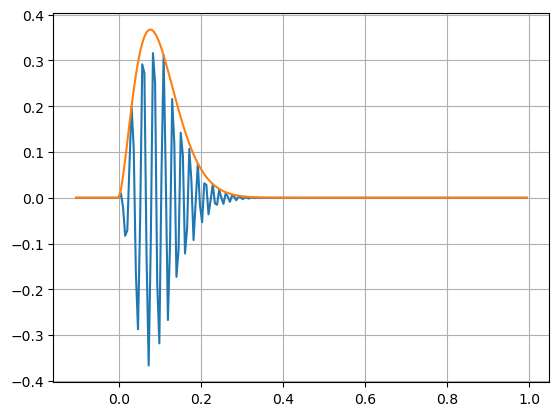

In [8]:
## Simulation of Zc clicks
import numpy as np
import matplotlib.pyplot as plt

def zcSig(tt,f0,fm,aa,bb,cc):
    return (aa*tt)**bb * np.exp(-(aa*tt)**cc + 2*np.pi*1j*(f0+fm*tt)*tt)

fs=192 #kHz
ts=1 #ms
tt=np.arange(0,ts,1/fs)

f0=30
fm=60
aa=13
bb=1.5
cc=1.5
ss=zcSig(tt,f0,fm,aa,bb,cc)
ss=np.append(np.zeros((20,1)),ss)
tt=(-20+np.arange(len(ss)))/fs
#tt=np.arange(-20/fs,ts,1/fs)

plt.plot(tt,np.real(ss));
plt.plot(tt,np.abs(ss));
plt.grid(True)
plt.show()


In [9]:
# Line array
c=1500      # m/s sound speed
d=0.0125    # hydrophone spacing (0.75/60)
N=10        # number of hydrophones
print('d:',d)
h=np.arange(N)*d

d: 0.0125


In [10]:
#
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
def fftfilt(b, x, zi=None):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig = x.shape[0]
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros(L_sig+L_F, dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros(L_sig+L_F)

    FDir = fft_func(b, n=L_F)

    # overlap and add
    for n in offsets:
        res[n:n+L_F] += ifft_func(fft_func(x[n:n+L_S], n=L_F)*FDir)

    if zi is not None:
        res[:zi.shape[0]] = res[:zi.shape[0]] + zi
        return res[:L_sig], res[L_sig:]
    else:
        return res[:L_sig]
    

### simulate measurements
- estimate the arrival times (up to a constant) for all hydrophones
- delay time series using a fractional sinc function

A sinc function is used as it is an all-pass filter with well defined delay proprty. Other interpolating low-pass filter may be used (e.g. Kaiser filters). The filters should be of FIR type to have well defined delay properties.

Here, to simplify algorithm, no integer resampling is done, requiring somewhat more coefficients to minimize edge effects.


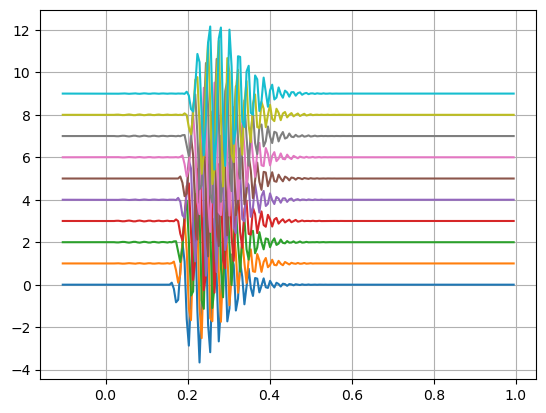

In [11]:
import scipy.signal as signal

fs=192000
#
if 0:
    # noise
    noise_power = 0.001 * fs / 2 
    ndat=fs//100
    M=np.random.normal(scale=np.sqrt(noise_power), size=(N,ndat))

    # estimate power spectral density (PSD)
    win=signal.get_window("hann",1024)
    f, Pxx_dens = signal.welch(M[0,:], fs=fs, nperseg=len(win), noverlap=0, scaling="density", window=win)

    plt.semilogy(f/1000, Pxx_dens)
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.ylim(1e-6,1e-1)
    plt.grid(True)

    plt.show()

# signal
iao=60  # simulated angle

xo=ss.real
# simulated delays relative to hydrophone 0
tau=np.arange(N)*d/c*np.cos(iao*np.pi/180)

yy=np.zeros((len(xo),N))

kk=np.arange(-30,30,1);
for ii in range(N):
    uu=np.sinc(kk-tau[ii]*fs)
    yy[:,ii]=fftfilt(uu,xo)

plt.plot(tt,yy*10+np.ones((yy.shape[0],1))*range(N))
plt.grid(True)
plt.show()



### check steering
To check method compensate simulated delay so that all hydrophone receive in parallel

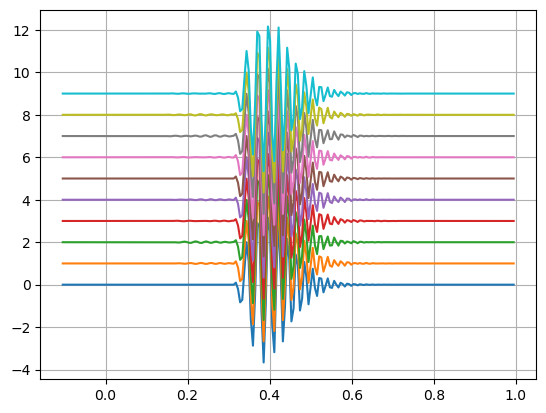

In [12]:
# check steering (replace sinc(kk-tau[ii]*fs) by sinc(kk+tau[ii]*fs))
vv=np.zeros((len(ss),N))
for ii in range(N):
    uu=np.sinc(kk+tau[ii]*fs)
    vv[:,ii]=fftfilt(uu,yy[:,ii])
plt.plot(tt,vv*10+np.ones((vv.shape[0],1))*range(N))
plt.grid(True)
plt.show()


### spatial filtering (beamformer)
 - Create first the filter coefficient matrix
 - filter all hydrophone using the adequate coefficients.
 - for each time step average all hydrophones

 inpection of the coefficients indicate that for the 0 and 180 deg cases edge effects may occur at the end of the array.

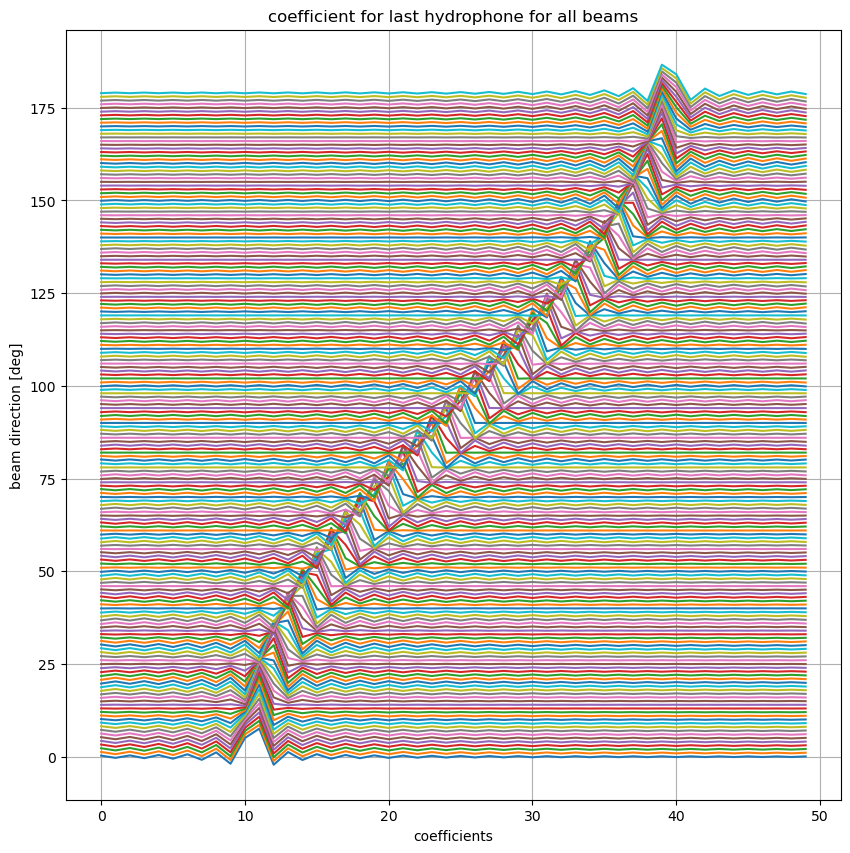

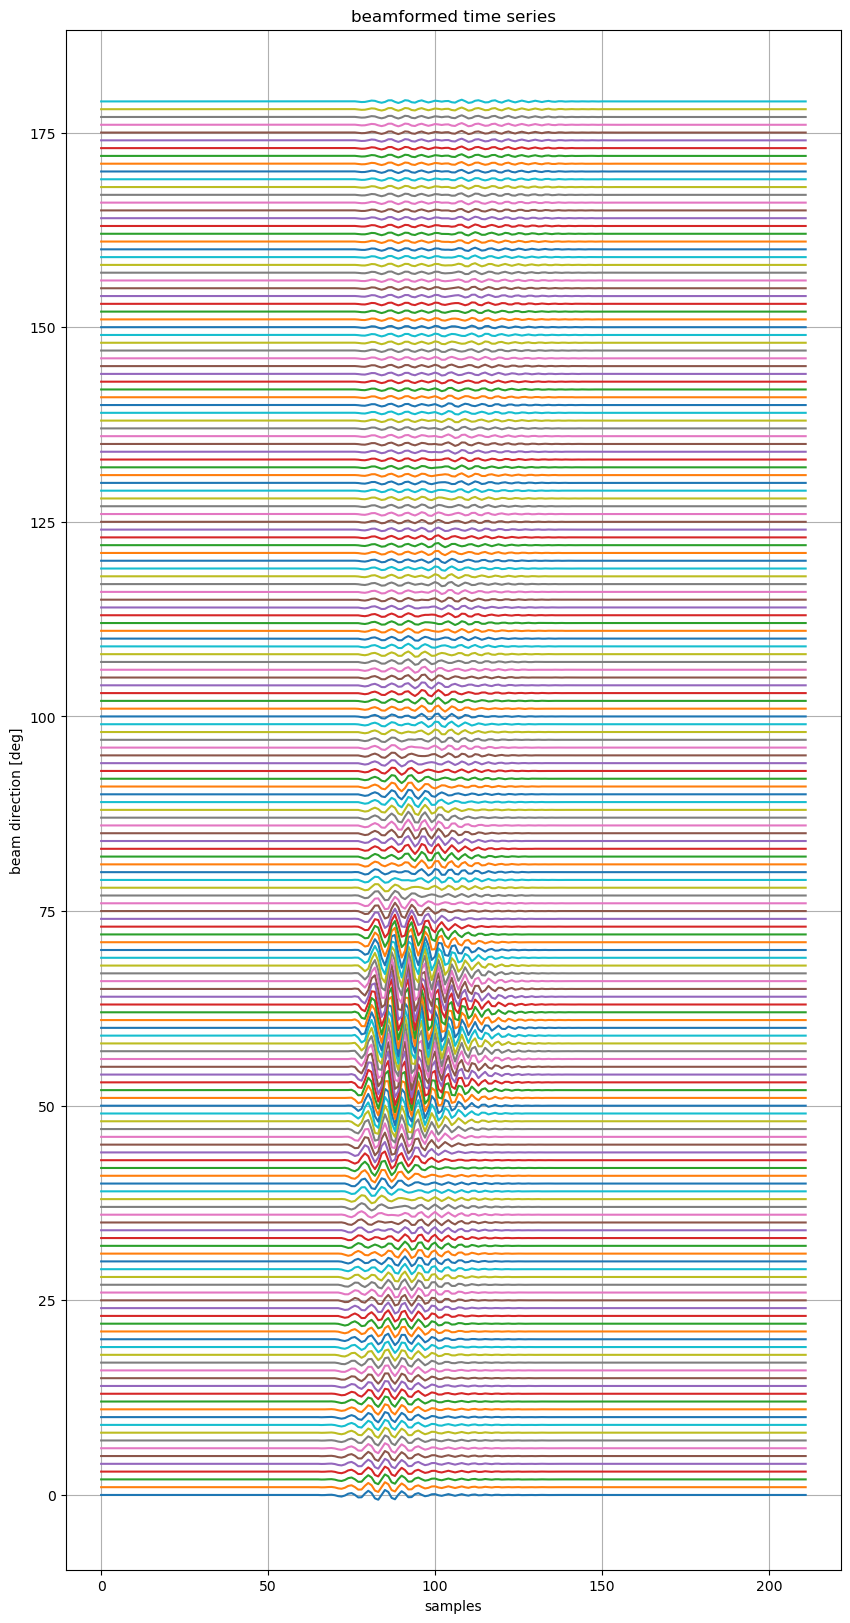

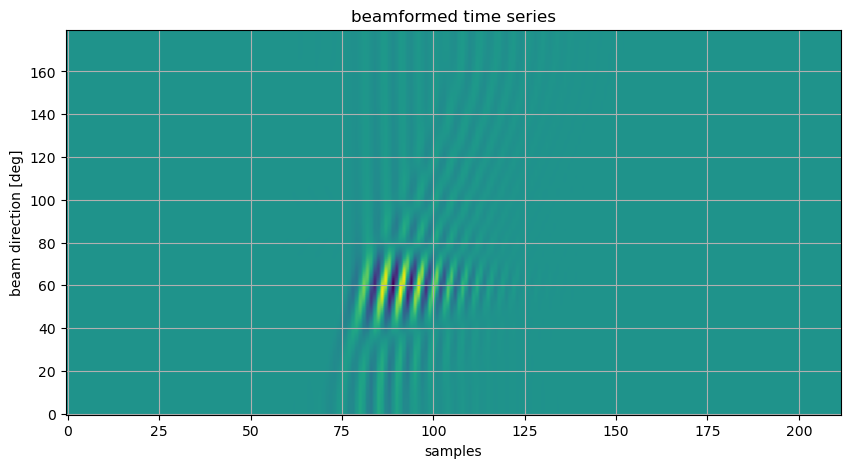

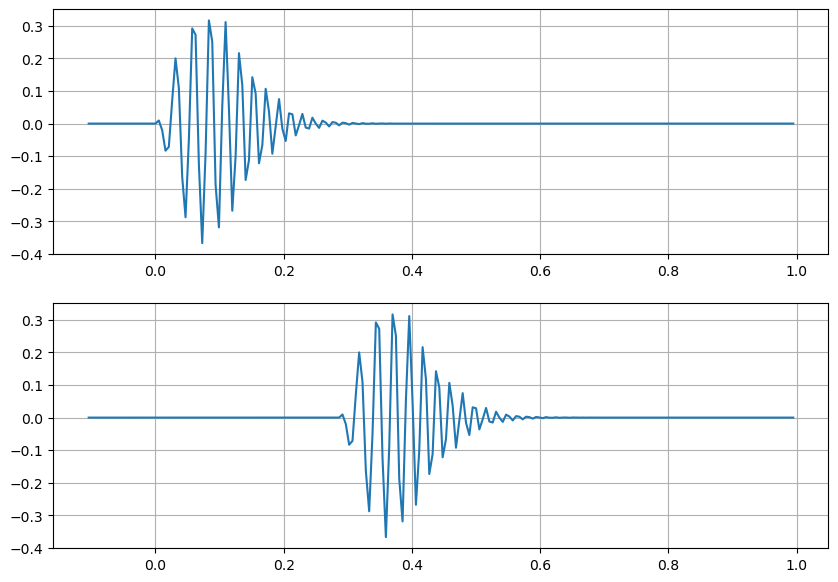

In [13]:
# beamformer

def delayMatrix(dd,maxDel):
    # generate delay coefficient matrix
    nc=np.ceil(maxDel)+10  # assume nimimum sinc coefficients: -10:10
    kk=np.arange(-nc,nc)
    #
    ww = np.zeros((len(kk),dd.shape[0],dd.shape[1]))
    for cc in range(ndir):              # over all beams
        for ii in range(N):             # over all hydrophones
            arg=kk+dd[ii,cc]
            ww[:,ii,cc]=np.sinc(arg)
    return ww


ndir=180
dd=h.reshape(-1,1)/c*np.cos(np.arange(ndir)/ndir*np.pi)*fs
maxDel=h[-1]/c*fs
ww=delayMatrix(dd,maxDel)

plt.figure(figsize=(10,10))
plt.title('coefficient for last hydrophone for all beams')
plt.plot(ww[:,-1,:]*10+np.ones((ww.shape[0],1))*range(ndir))
plt.xlabel('coefficients')
plt.ylabel('beam direction [deg]')
plt.grid(True)
plt.show()
# filter data (beamformer)
def beamform(ww,yy):
    vv=np.zeros(yy.shape)
    zz=np.zeros((yy.shape[0],ww.shape[2]))
    for cc in range(ndir):              # over all beams
        for ii in range(N):             # over all hydrophones
            vv[:,ii]=fftfilt(ww[:,ii,cc],yy[:,ii])
        zz[:,cc]=np.mean(vv,axis=1)     # sum hydrophones for each beam
    return zz
#
zz=beamform(ww,yy)
plt.figure(figsize=(10,20))
plt.title('beamformed time series')
plt.plot(zz*10+np.ones((zz.shape[0],1))*range(ndir))
plt.xlabel('samples')
plt.ylabel('beam direction [deg]')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.title('beamformed time series')
plt.imshow(zz.T,aspect='auto',origin='lower')
plt.xlabel('samples')
plt.ylabel('beam direction [deg]')
plt.grid(True)
plt.show()

#
# compare with input signal
plt.figure(figsize=(10,7))
plt.subplot(211)
plt.plot(tt,ss.real)
plt.grid(True)
plt.subplot(212)
plt.plot(tt,zz[:,iao])
plt.grid(True)
plt.show()
